# Introudaction to Computer Vision - Final Project - Plant Pathology 2021 FCVG
## Shahar Michaeli 

**Hello to you!**
As part of the final project of the Introduction to Computer Vision course, we are required to build a notebook as part of a competition at Kaggle on a variety of topics such as classification and segmentation.
I decided to choose the classification as a personal choice and chose FGVC8's Plant Pathology competition - which is a classification competition.


**The main objective** of the competition is to develop machine learning-based models to accurately classify a given leaf image from the test dataset to a particular disease category and to identify an individual disease from multiple disease symptoms on a single leaf image. 



**Dataset Description:**
The dataset includes about 18,000 images of leaves, the vast majority of the dataset is images for training while only the test has only three images.
Another thing included in the dataset is the CSV file which is the metadata and it includes the names of all the training images and their labels.

In [ ]:
# imports
import torch
import os
from albumentations.pytorch import ToTensorV2
import numpy as np
import torchvision.models as models
import tensorflow as tf
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import torch.nn as nn
import torchmetrics 
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import pandas as pd
import cv2
from tqdm import tqdm
%matplotlib inline

In [ ]:
# Glboal Variabels.
PATH = "../input/plant-pathology-2021-fgvc8/"
TRAIN_DIR_RESIZED = '../input/resized-plant2021/img_sz_256/'
TRAIN_DIR = PATH + 'train_images/'
TEST_DIR = PATH + 'test_images/'

# Plant Pathology 2021 FCVG - EDA


In [ ]:
train_dataframe_csv = pd.read_csv(PATH + "train.csv")
train_dataframe_csv

image                           labels
0      800113bb65efe69e.jpg                          healthy
1      8002cb321f8bfcdf.jpg  scab frog_eye_leaf_spot complex
2      80070f7fb5e2ccaa.jpg                             scab
3      80077517781fb94f.jpg                             scab
4      800cbf0ff87721f8.jpg                          complex
...                     ...                              ...
18627  fffb900a92289a33.jpg                          healthy
18628  fffc488fa4c0e80c.jpg                             scab
18629  fffc94e092a59086.jpg                             rust
18630  fffe105cf6808292.jpg          scab frog_eye_leaf_spot
18631  fffe472a0001bd25.jpg                          healthy

[18632 rows x 2 columns]

## Visualize Sample Leaves

In [ ]:
def visualize_batch(path,image_ids, labels):
    plt.figure(figsize=(20, 12))
    
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 4, ind + 1)
        image = cv2.imread(os.path.join(path, image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"Class: {label}", fontsize=12)
        plt.axis("off")
    plt.show()
    
def show_class(class_name, examples=4, labels_df=train_dataframe_csv, train_images_path=TRAIN_DIR_RESIZED):
    image_list = labels_df[labels_df['labels'] == class_name]['image'].sample(frac=1)[:examples].to_list()
    plt.figure(figsize=(25,12))
    for i, img in enumerate(image_list):
        plt.subplot(1 ,examples, i+1)
        image = cv2.imread(os.path.join(train_images_path, img))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')
    plt.show()


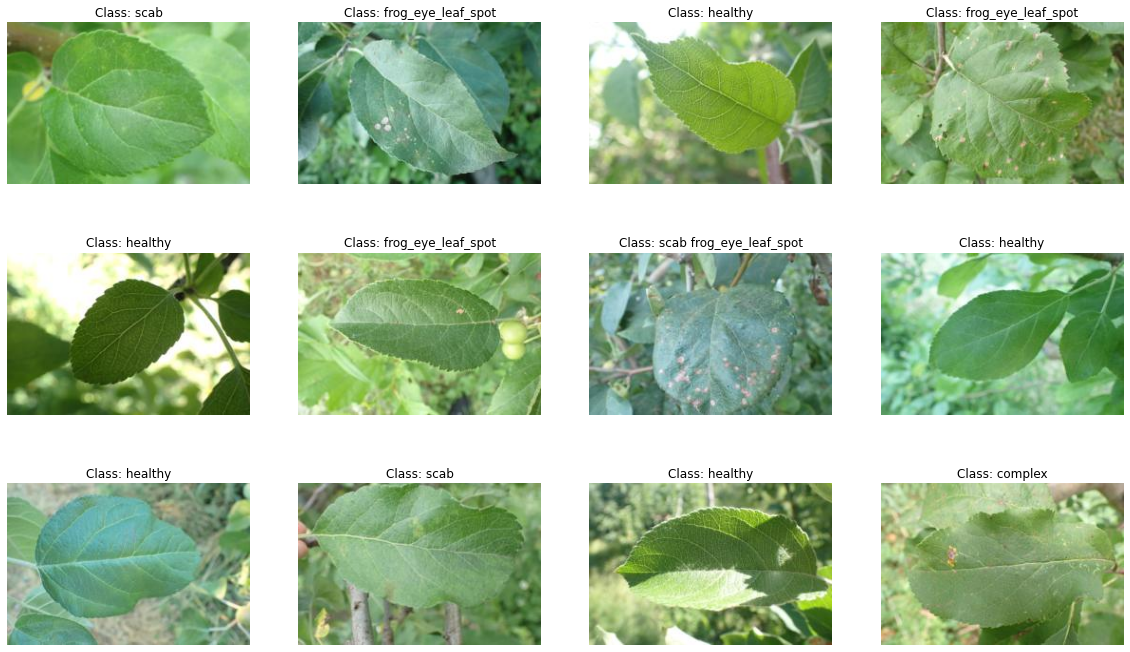

In [ ]:
tmp_df = train_dataframe_csv.sample(12)
image_ids = tmp_df["image"].values
labels = tmp_df["labels"].values
visualize_batch(TRAIN_DIR_RESIZED,image_ids,labels)

## Frequency of Each Class - Labels Histogram
At first glance you can see that there are 12 labels, but if you look closely, it seems that half of them are a combination of the unique labels, so you can see that there are only 6 unique and these are: 
* scab
* frog_eye_leaf_spot
* rust
* complex
* powdery_midlew
* healthy

Since these are diseases, we will therefore separate the healthy from the five by drop the column of the healthy on labels column.


Text(0.5, 1.0, 'Labels Histogram - Train Images')

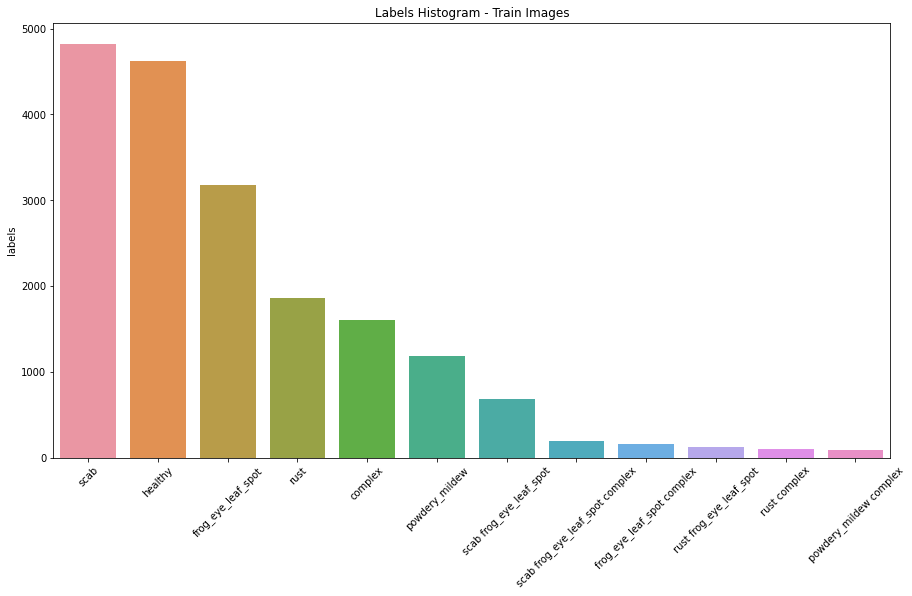

In [ ]:
plt.figure(figsize=(15,8))
labels_plot = sns.barplot(x = train_dataframe_csv.labels.value_counts().index,y = train_dataframe_csv.labels.value_counts())
for item in labels_plot.get_xticklabels():
    item.set_rotation(45)
    
labels_plot.set_title('Labels Histogram - Train Images')

We can see the dataset is not balanced at all, there are big differences between 'scab' , 'healthy' and 'frog_eye_leaf_spot' to others. </br> To be able to classify correctly we will need to try to understand how to answer the following questions:
1. How to identify each disease type?
2. What characteristics of each disease type?

### 1. Healthy
Clean and green leaves without any holes or marks.

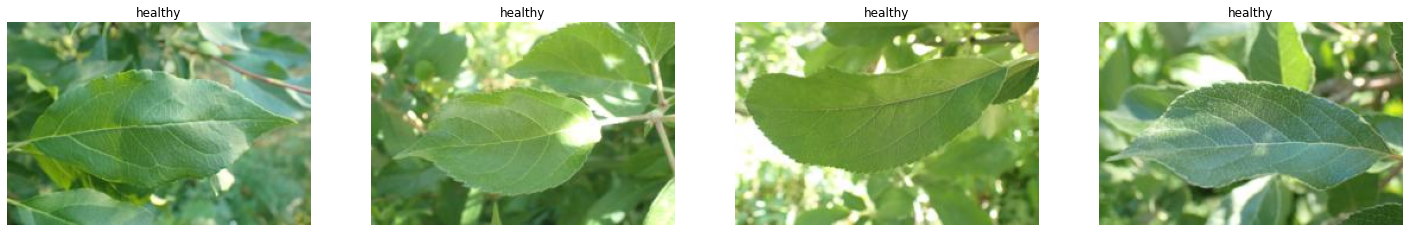

In [ ]:
show_class(class_name='healthy', examples=4)

### 2. Scab
Scab is a serious disease of apples and ornamental crabapples, apple scab (Venturia inaequalis) attacks both leaves and fruit. The fungal disease forms pale yellow or olive-green spots on the upper surface of leaves.

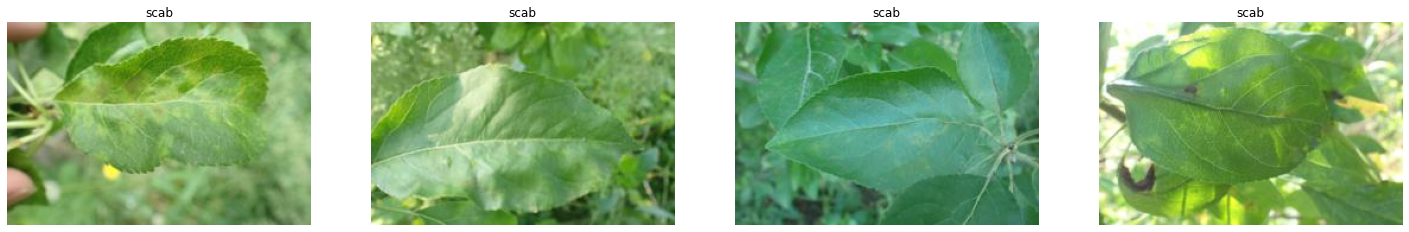

In [ ]:
show_class(class_name='scab', examples=4)

### 3. Frog eye leaf spot
First, small purple spots form on the leaves. These spots gradually enlarge and eventually develop into lesions with a light tan interior, surrounded by a dark purple perimeter. Heavy infections of frog-eye leaf spots can cause leaves to turn yellow and drop.

Frog eye leaf spot symptoms on tree trunks and limbs appear as cankers, which are reddish-brown in color and are slightly sunken. As the wood ages, it becomes shrunken and layers of bark begin to peel back.

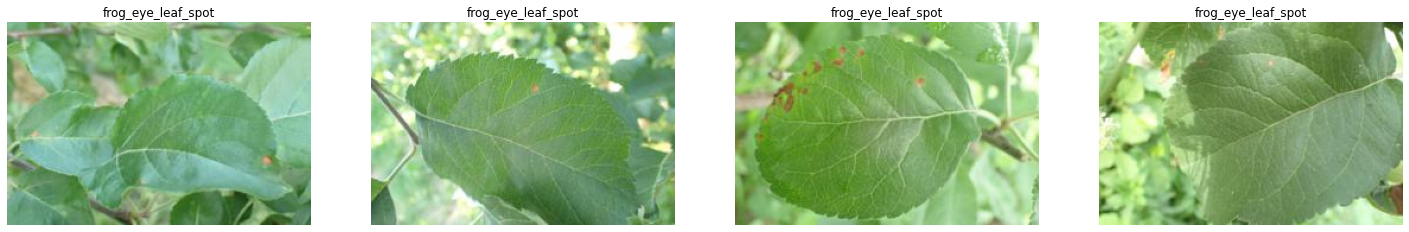

In [ ]:
show_class(class_name='frog_eye_leaf_spot', examples=4)

### 4. Complex
According to data description: Unhealthy leaves with too many diseases to classify visually will have the complex class, and may also have a subset of the diseases identified.

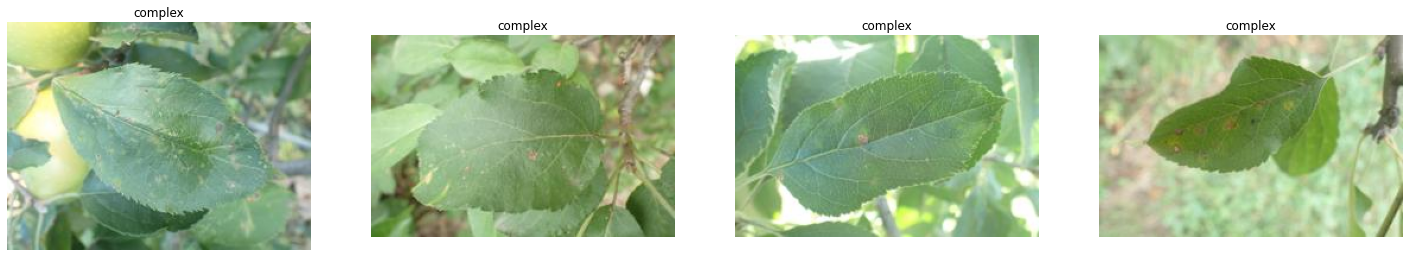

In [ ]:
show_class(class_name='complex', examples=4)

### 5. Rust
Yellow round spots (lesions) appear on the upper surfaces of the leaves shortly after flowering. In late summer clusters of brown threads or cylindrical tubes (aecia) appear under the yellow leaf spots or on fruits and branches. The spores attached to wires or tubes infect the leaves (needles) and juniper twigs in wet and hot weather.

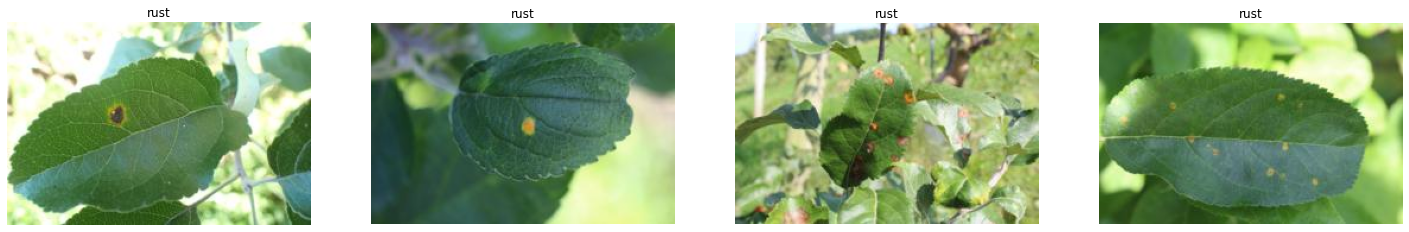

In [ ]:
show_class(class_name='rust', examples=4)

### 6. Powdery Mildew
Powdery mildew is one of the easiest plant diseases to detect, as its symptoms are quite noticeable. Infected plants show white powdery spots on the leaves and stems. The lower leaves are most affected, but the moss can appear in any part above the ground of the plant. As the disease progresses, the spots grow as a large number of asexual spores form, and the moss may spread up and down the plant.

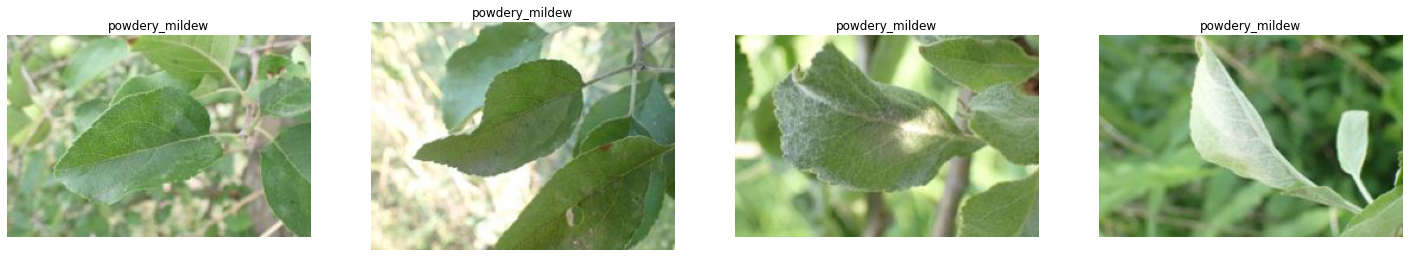

In [ ]:
show_class(class_name='powdery_mildew', examples=4)

# One Hot Encoder Labels
Once we understand that there are 6 unique labels and not 12, and also that there can be some unique labels then a multi-label classification is required here and the best method to do this is by One Hot Encoder. \
One hot encoding is a representation of categorical variables as binary vectors. This first requires that the categorical values be mapped to integer values. Then, each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a 1.
</br> One Hot Encoder will help to provide a better classification since we can use CNN to give a score to each disease for each image.

![image](https://user-images.githubusercontent.com/49268387/121418068-3efb2300-c973-11eb-9cd7-2dc48ad7ff57.png)

We will use MultiLabelBinarizer to easily map each image label to Vector One Hot Encoder. </br>
Since there are six different unique labels and most of them (five) are diseases, we would like to delete the healthy label and thus give a separation between the diseased and the healthy leaves.

In [ ]:
mlb = MultiLabelBinarizer()
train_dataframe_csv['labels'] = [x.split(' ') for x in train_dataframe_csv['labels']]
OneHotEncoder_Labels = mlb.fit_transform(train_dataframe_csv["labels"])

In [ ]:
for i in range(len(train_dataframe_csv)):
    train_dataframe_csv.at[i,'labels'] = np.delete(OneHotEncoder_Labels[i],2) # Drop the healthy column
    
train_dataframe_csv

image           labels
0      800113bb65efe69e.jpg  [0, 0, 0, 0, 0]
1      8002cb321f8bfcdf.jpg  [1, 1, 0, 0, 1]
2      80070f7fb5e2ccaa.jpg  [0, 0, 0, 0, 1]
3      80077517781fb94f.jpg  [0, 0, 0, 0, 1]
4      800cbf0ff87721f8.jpg  [1, 0, 0, 0, 0]
...                     ...              ...
18627  fffb900a92289a33.jpg  [0, 0, 0, 0, 0]
18628  fffc488fa4c0e80c.jpg  [0, 0, 0, 0, 1]
18629  fffc94e092a59086.jpg  [0, 0, 0, 1, 0]
18630  fffe105cf6808292.jpg  [0, 1, 0, 0, 1]
18631  fffe472a0001bd25.jpg  [0, 0, 0, 0, 0]

[18632 rows x 2 columns]

In [ ]:
print(mlb.classes_)

['complex' 'frog_eye_leaf_spot' 'healthy' 'powdery_mildew' 'rust' 'scab']


In [ ]:
labels_dict = {'complex': 0 , 'frog_eye_leaf_spot':1,'powdery_mildew':2,'rust':3,'scab':4}

### Train and Test Datasets - Ready for Model!
Add to each image id the image path to read from.


In [ ]:
train_dataframe_csv['image'] = train_dataframe_csv.apply(lambda row: TRAIN_DIR_RESIZED + row.image , axis=1)
train_dataframe_csv

image           labels
0      ../input/resized-plant2021/img_sz_256/800113bb...  [0, 0, 0, 0, 0]
1      ../input/resized-plant2021/img_sz_256/8002cb32...  [1, 1, 0, 0, 1]
2      ../input/resized-plant2021/img_sz_256/80070f7f...  [0, 0, 0, 0, 1]
3      ../input/resized-plant2021/img_sz_256/80077517...  [0, 0, 0, 0, 1]
4      ../input/resized-plant2021/img_sz_256/800cbf0f...  [1, 0, 0, 0, 0]
...                                                  ...              ...
18627  ../input/resized-plant2021/img_sz_256/fffb900a...  [0, 0, 0, 0, 0]
18628  ../input/resized-plant2021/img_sz_256/fffc488f...  [0, 0, 0, 0, 1]
18629  ../input/resized-plant2021/img_sz_256/fffc94e0...  [0, 0, 0, 1, 0]
18630  ../input/resized-plant2021/img_sz_256/fffe105c...  [0, 1, 0, 0, 1]
18631  ../input/resized-plant2021/img_sz_256/fffe472a...  [0, 0, 0, 0, 0]

[18632 rows x 2 columns]

In [ ]:
test_dataframe_csv = pd.read_csv(PATH + "sample_submission.csv")
test_dataframe_csv['image'] = test_dataframe_csv.apply(lambda row: TEST_DIR + row.image , axis=1)

test_dataframe_csv

image   labels
0  ../input/plant-pathology-2021-fgvc8/test_image...  healthy
1  ../input/plant-pathology-2021-fgvc8/test_image...  healthy
2  ../input/plant-pathology-2021-fgvc8/test_image...  healthy

# Utils - Dataset class, Augmentation Transformers, Train and Validation Functions

In [ ]:
class PlantDataset(Dataset):
    def __init__(self, df, transform=None):
        self.images = df['image'].values
        self.labels = df['labels'].values
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]
        image = cv2.imread(image_path,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image,(224,224))
        if self.transform is not None:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image,label
    
def get_transform(phase: str):
    if phase == 'train':
        return A.Compose([
            A.RandomResizedCrop(height=224, width=224),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.Normalize(),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Resize(height=224, width=224),
            A.Normalize(),
            ToTensorV2(),
        ])

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def getLabel(valueToFind):
    for key,value in labels_dict.items():
        if value == valueToFind:
            return key
        
def cleanLabels(labels):
    if len(labels) == 0:
        return ['healthy']
    return list(dict.fromkeys(labels))

In [ ]:
def train(dataloader,model,optimizer,epoch, lossFunction):
    F1metric = torchmetrics.F1(5, average='weighted')
    sigmoid = nn.Sigmoid()
    model.train()
    
    
    acc = AverageMeter()
    losses = AverageMeter()
    accuracies = 0
    loss_accumlated = 0
    for x_batch, y_batch in dataloader:
        optimizer.zero_grad()
        x_batch = x_batch.float().cuda()
        y_batch = y_batch.float().cuda()
        output = model(x_batch)
        loss = lossFunction(output, y_batch)

        loss.backward()
        losses.update(loss.item(),x_batch.size(0))
        loss_accumlated += loss.item()
        optimizer.step()
        accuracy = F1metric(sigmoid(output).to('cpu'),y_batch.to('cpu'))

        accuracies += accuracy
        acc.update(accuracy, x_batch.size(0))
        del x_batch
        del y_batch
        torch.cuda.empty_cache()

    return losses.avg,acc.avg*100

In [ ]:
def validation(dataloader,model,optimizer,epoch, lossFunction):
    F1metric = torchmetrics.F1(5, average='weighted')
    sigmoid = nn.Sigmoid()    
    
    model.eval()
    acc = AverageMeter()
    losses = AverageMeter()
    loss_accumlated = 0
    accuracies = 0

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.float().cuda()
            y_batch = y_batch.float().cuda()
            output = model(x_batch)
            loss = lossFunction(output, y_batch)

            losses.update(loss.item(), x_batch.size(0))
            loss_accumlated += loss.item()
            accuracy = F1metric(sigmoid(output).to('cpu'),y_batch.to('cpu'))
            accuracies += accuracy
            acc.update(accuracy, x_batch.size(0))
            del x_batch
            del y_batch
            torch.cuda.empty_cache()
        
    return losses.avg,acc.avg*100

# Multi-Label Classifier Model Metrics

As part of the model improvement process after using the metrics we used during the semester like Accuracy and Focal Loss, the submission result was really low. </br> After some pretty in-depth research on the subject I realized that the labels need to be transferred to the One Hot Encoder form to make the model better predictable, then each leaf can have several diseases at once so classification by number of different classes before One Hot Encoder classification is incorrect. Therefore, it is necessary to find new indices, I was present to find that there is an index that replaces Accuracy is an index called F1 that performs a harmonic mean between Recall and Precision, in other words, an average between the accuracy of the TP prediction and the accuracy of the FP. The diseases.

Another measure is the switch to Focal Loss, because after switching to One Hot Encoder, the labels are vectors that contain zeros and ones and the model emits a probability vector for each of the different classes, so I switched to Binary Cross Entropy which measures binary label vectors versus a probability vector. And finally an average operation.

## 1. F1 Metric
Since we are using MultiLabelBinarizer to encode each image label to One Hot Encoder (Multi-Label Encoder) we need a metric to evaluate our model as a Multi-Label classifier model. </br>
My suggestion is to use the F1 metric - The F1 score for a certain class is the harmonic mean of its precision and recall, so it’s an overall measure of the quality of a classifier’s predictions. It is usually the metric of choice for most people because it captures both precision and recall.

![image](https://user-images.githubusercontent.com/49268387/123552087-3aa97500-d77d-11eb-8fb5-074d9a676bf7.png)

</br>
To refine the F1 metric and its use of Precision and Recall we will define the following concepts: </br>

* Precision : Precision is the proportion of correct predictions among all predictions of a certain class. In other words, it is the proportion of true positives among all positive predictions.

    ![image](https://user-images.githubusercontent.com/49268387/123552020-f4ecac80-d77c-11eb-824c-5bfa8939c076.png)

    For example, if we look at the scab class, the number of times the model predicted a scab leaf is 2, and only one of them was a correct prediction. Therefore the precision would be 1 / 2 = 0.5 = 50%.

* Recall : Recall is the proportion of examples of a certain class that have been predicted by the model as belonging to that class. In other words, it is the proportion of true positives among all true examples.

    ![image](https://user-images.githubusercontent.com/49268387/123551937-9aebe700-d77c-11eb-8f5d-1ad3ff763703.png)




## 2. Binary Cross-Entropy Loss Function
Another metric to evaluate our model as a Multi-Label classifier model is Binary Cross Entropy as loss function. </br>
Binary Cross Entropy is suitable for us because our model gives a score for each disease and the score is between the numbers 0 and 1 while the labels are 1 or 0, so you can measure the values and thus measure the model in the best way possible.  </br>
This loss function is used for measuring the error between two probabilities vectors, and for each index a comparison is made by the following formula:

![image](https://user-images.githubusercontent.com/49268387/123549924-bd2d3700-d773-11eb-8c15-00c65333c835.png)



# Submission 
Since this competition has been restricted to the following three restrictions :
1. CPU Notebook <= 9 hours run-time
2. GPU Notebook <= 2 hours run-time
3. Internet access disabled

I found out that many of the participants in this competition used another notebook to train their model and thus allow flexibility for their training without unnecessary restrictions and thus achieve the best results so I also decided to exercise this option and thus not be subject to these restrictions, so I trained models in the second notebook the model using torch.save() to save the model and in this notebook I used torch.load() to load the model I trained and all that left to do is run the model on test images.

The other notebooks can be found at the following links:
1. [My GoogleNet Notebook](https://www.kaggle.com/shaharm/notebook72dc7b2258)
2. [My DenseNet Notebook](https://www.kaggle.com/shaharm/shahar-third-notebook)

In [ ]:
# images_train, images_valid, labels_train, labels_valid = train_test_split(train_dataframe_csv['image'].values, train_dataframe_csv['labels'].values, test_size=0.2)

# train_dataframe = pd.DataFrame(data = {'image': images_train,'labels':labels_train})
# valid_dataframe = pd.DataFrame(data = {'image': images_valid,'labels':labels_valid})

# train_dataset = PlantDataset(train_dataframe, get_transform('train'))
# valid_dataset = PlantDataset(valid_dataframe, get_transform('valid'))
test_dataset = PlantDataset(test_dataframe_csv, get_transform('valid'))

# BatchSize = 256
# train_loader = DataLoader(train_dataset, batch_size=BatchSize, shuffle=True, num_workers=1)
# valid_loader = DataLoader(train_dataset, batch_size=BatchSize, shuffle=True, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1)

In [ ]:
googlenet_model = torch.load('../input/notebook72dc7b2258/myGoogleNetPretrainedModel3.h5')

# googlenet_model = models.googlenet(pretrained=False,init_weights = True)
# in_features = googlenet_model.fc.in_features
# googlenet_model.fc = torch.nn.Linear(in_features, 5)
# googlenet_model = googlenet_model.cuda()

criterion = nn.BCEWithLogitsLoss()
opt = optim.Adam(googlenet_model.parameters())


In [ ]:
# losses_train = []
# losses_valid = []
# accs_train = []
# accs_valid = []
# EPOCHS = 30

# for e in tqdm(range(EPOCHS),desc="Epoch", position=0):
#     loss_train,acc_train = train(train_loader,googlenet_model,opt,e,criterion)
#     losses_train.append(loss_train)
#     accs_train.append(acc_train)

#     loss_valid,acc_valid = validation(valid_loader,googlenet_model,opt,e, 
#                                       criterion)
#     losses_valid.append(loss_valid)
#     accs_valid.append(acc_valid)

In [ ]:
submission = pd.DataFrame(columns=['image','labels'])

In [ ]:
googlenet_model.eval()
count = 0
for image,label in test_loader:
    with torch.no_grad():
        pred = googlenet_model(image.float().cuda()) 
        pred = torch.sigmoid(pred)
        pred = pred.to('cpu').numpy().tolist()[0]
        print(pred)
        labels = [getLabel(index) for index,value in enumerate(pred) if value > 0.25]
        labels = cleanLabels(labels)
        labels = ' '.join(labels)
        submission = submission.append({'image':test_dataframe_csv['image'].values[count].split('/')[-1],'labels':labels},ignore_index=True)
        count += 1

    del pred
    torch.cuda.empty_cache()

[0.2657506763935089, 0.021214913576841354, 0.017594223842024803, 0.0017971958732232451, 0.20974205434322357]
[0.9966421127319336, 0.000784832751378417, 1.4449051732867702e-08, 0.0041268737986683846, 0.0005043001146987081]
[0.2257186472415924, 0.9999562501907349, 1.3540141452494936e-08, 1.139937069183361e-07, 0.9863955974578857]


In [ ]:
submission

image                   labels
0  85f8cb619c66b863.jpg                  complex
1  ad8770db05586b59.jpg                  complex
2  c7b03e718489f3ca.jpg  frog_eye_leaf_spot scab

In [ ]:
submission.to_csv('./submission.csv',index=False)

# Summary
During the preparation of the project I trained many models and tried to achieve the best result in submission, then I was surprised to find that only 2 models managed to bring me to the best results. </br>
The most successful model I had during project preparation was the pre-trained GoogleNet combined with the Adam Optimizer and 150 epochs training. 
I was able to come up with this model with 95% accuracy in training and also in validation!

GoogleNet - Accuracy and Loss on Training :

![image](https://user-images.githubusercontent.com/49268387/123550406-f8306a00-d775-11eb-9cf4-c6dd51b28f07.png)

GoogleNet - Accuracy and Loss on Validation :

![image](https://user-images.githubusercontent.com/49268387/123550420-08484980-d776-11eb-958e-5a780a6b17ac.png)


GoogleNet - Submission Leaderboard Score (Best Score) : 

![image](https://user-images.githubusercontent.com/49268387/123546471-50ab3b80-d765-11eb-983a-289d501fc2da.png)


Immediately after GoogleNet model was DenseNet model combined with Adam Optimizer and 70 epochs training.I reached with DenseNet model to accuracy of 86% percent in training and also in validation!

DenseNet - Accuracy and Loss on Training :

![image](https://user-images.githubusercontent.com/49268387/123551477-9a525100-d77a-11eb-8a4c-6fbced514430.png)

DenseNet - Accuracy and Loss on Validation :

![image](https://user-images.githubusercontent.com/49268387/123551487-a807d680-d77a-11eb-9ab3-c6def696fbcc.png)


# References 
Links that I used.
1. [Detailed EDA & Baseline Model: Plant Pathology 21](https://www.kaggle.com/manabendrarout/detailed-eda-baseline-model-plant-pathology-21)
2. [Understanding Binary Cross Entropy](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a)
3. [BCEWithLogitsLoss PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)
4. [Precision, Recall, Accuracy, and F1 Score for Multi-Label Classification](https://medium.com/synthesio-engineering/precision-accuracy-and-f1-score-for-multi-label-classification-34ac6bdfb404)